# Import Libraries

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import os
from PIL import Image
import matplotlib.image as mpimg
import cv2
import shutil


!pip install torchmetrics
import torchmetrics

# Import Data

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [8]:
# List files in the dataset directory
dataset_files = os.listdir(path)
print("Files in the dataset:", dataset_files)


Files in the dataset: ['hmnist_28_28_L.csv', 'HAM10000_images_part_2', 'hmnist_8_8_L.csv', 'HAM10000_images_part_1', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'ham10000_images_part_1', 'ham10000_images_part_2', 'HAM10000_metadata.csv']


# Viewing the Images

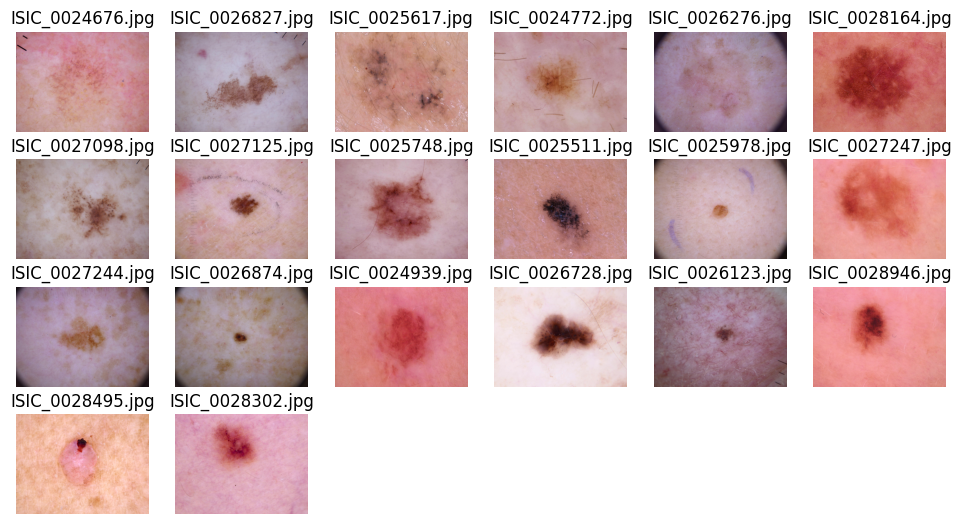

In [9]:
# Display a few images
image_folder = os.path.join(path, "HAM10000_images_part_1")  # Adjust if necessary
sample_images = os.listdir(image_folder)[10:30]  # Show first 5 images

plt.figure(figsize=(12, 8))
for idx, img_file in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_file)
    img = mpimg.imread(img_path)

    plt.subplot(5, 6, idx + 1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis("off")

plt.show()

# Inspecting the size of the images

In [10]:
# This is to check if all the images are the same size

# Path to your dataset folder
image_folder = os.path.join(path, "HAM10000_images_part_1") # Adjust if necessary
image_folder2 = os.path.join(path, "HAM10000_images_part_2") # Adjust if necessary

# To store sizes
image_sizes = set()
print(len(os.listdir(image_folder)))
print(len(os.listdir(image_folder2)))

# Loop through all files in the dataset
for image_file in os.listdir(image_folder):
    if image_file.endswith(('.jpg', '.jpeg', '.png')):  # adjust if necessary
        image_path = os.path.join(image_folder, image_file)  # Fixed the path here
        with Image.open(image_path) as img:
            image_sizes.add(img.size)  # Add the size to the set


# Check if all images have the same size
if len(image_sizes) == 1:
    print("All images have the same size:", image_sizes.pop())
else:
    print("Images have different sizes:", image_sizes)



5000
5015
All images have the same size: (600, 450)


In [11]:
# Define the path to the image folder (adjust if needed based on output of previous step)
image_folder = os.path.join(path, "HAM10000_images_part_1")

# List the first few images in this folder
sample_images = os.listdir(image_folder)
print("Sample images:", sample_images[:5])

image_path = os.path.join(image_folder, sample_images[0])
# Load image and check dimensions
img = cv2.imread(image_path)
height, width, channels = img.shape
print("Image size:", (width, height))

Sample images: ['ISIC_0028404.jpg', 'ISIC_0028066.jpg', 'ISIC_0025073.jpg', 'ISIC_0026903.jpg', 'ISIC_0028285.jpg']
Image size: (600, 450)


# Exploratory Data Analysis

## Exploring the hmnist and meta data files

In [12]:
hmnist_file = os.path.join(path, "hmnist_28_28_RGB.csv")
data = pd.read_csv(hmnist_file)
data

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


In [13]:
data.info()
data.columns
data.isnull().any().sum()
y = data['label']
x = data.drop(columns = ['label'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Columns: 2353 entries, pixel0000 to label
dtypes: int64(2353)
memory usage: 179.8 MB


At this point we can see that as we assumed there are 28 * 28 * 3 + 1 columns for all the 10015 data points. it's multiplied by three for each of RGB and the last col. is the label.
Labels are numbered from 0 to 6.

In [14]:
meta_data_file = os.path.join(path, "HAM10000_metadata.csv")
meta_data = pd.read_csv(meta_data_file)
meta_data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [15]:
#classes = {'mel': 0 ,'vasc': 1,'df': 2,'nv': 3,'bkl': 4,'bcc': 5,'ak': 6}
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}


## Distribution of Sex

Text(0.5, 1.0, 'Distribution of Sex')

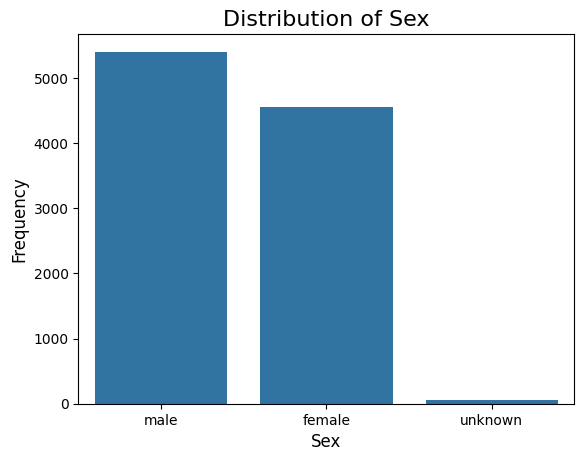

In [16]:
sns.countplot(x = 'sex', data = meta_data)
plt.xlabel('Sex', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Distribution of Sex', size=16)

## Distribution of Age

Text(0.5, 1.0, 'Histogram of Age of Patients')

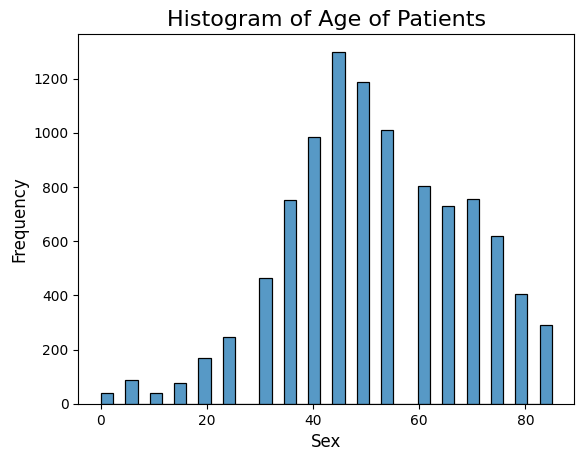

In [17]:
bar, ax = plt.subplots()
sns.histplot(meta_data['age'])
plt.xlabel('Sex', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Histogram of Age of Patients', size=16)

## Distribution of Diseased Areas

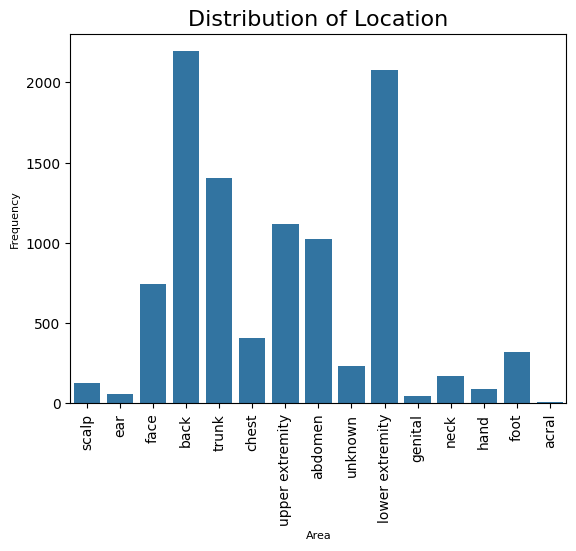

In [18]:
plt.figure()
sns.countplot(x='localization', data=meta_data)
plt.xlabel('Area', size=8)
plt.ylabel('Frequency', size=8)
plt.title('Distribution of Location', size=16)
plt.xticks(rotation=90)
plt.show()

## Distribution of Types

Text(0.5, 1.0, 'Distribution of Types')

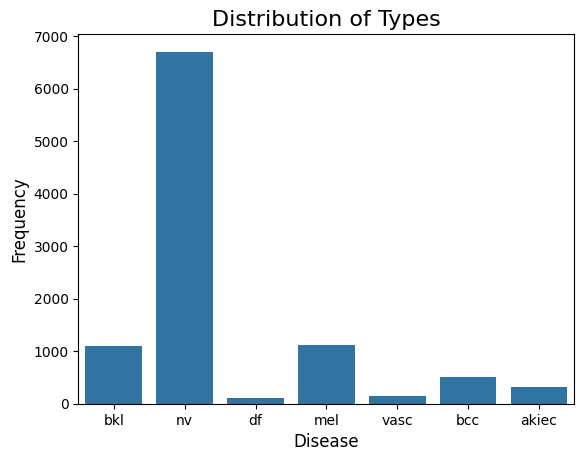

In [19]:
sns.countplot(x = 'dx', data = meta_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Distribution of Types', size=16)

## Distribution of Types over Gender

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

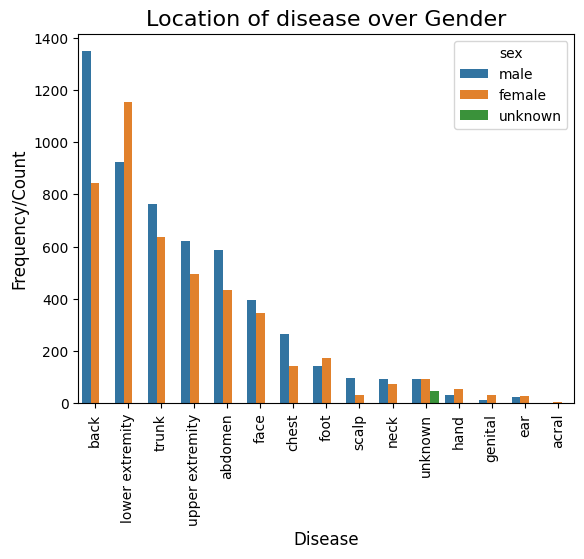

In [20]:
value = meta_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots()
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

# Define a custom Dataset class to integrate our data to PyTorch

In [21]:
transform = transforms.Compose([
    transforms.Resize((244, 244)),  # Resize images to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust based on your dataset stats
])

In [22]:
class SkinCancerDataset(Dataset):


    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Get the image path and label
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 1]+".jpg")
        image = Image.open(img_name).convert("RGB")

        # Define mapping from var1 short codes to labels
        label_mapping = {
            "akiec": 0,  # Actinic keratoses and intraepithelial carcinoma / Bowen's disease
            "bcc": 1,    # Basal cell carcinoma
            "bkl": 2,    # Benign keratosis-like lesions
            "df": 3,     # Dermatofibroma
            "mel": 4,    # Melanoma
            "nv": 5,     # Melanocytic nevi
            "vasc": 6    # Vascular lesions
        }

        # Convert the label to an integer
        label = int(label_mapping.get(self.annotations.iloc[idx, 2], -1))

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

## merging part1 and part 2 of images into one directory

In [23]:
# Paths to original folders
path_part_1 = os.path.join(path, "HAM10000_images_part_1")
path_part_2 = os.path.join(path, "HAM10000_images_part_2")
combined_dir = os.path.join(path, "HAM10000_images_combined")

# Create combined directory if it doesn't exist
os.makedirs(combined_dir, exist_ok=True)

# Move images from part_1
for filename in os.listdir(path_part_1):
    source = os.path.join(path_part_1, filename)
    destination = os.path.join(combined_dir, filename)
    shutil.move(source, destination)

# Move images from part_2
for filename in os.listdir(path_part_2):
    source = os.path.join(path_part_2, filename)
    destination = os.path.join(combined_dir, filename)
    shutil.move(source, destination)

print("Images from both folders have been merged into", combined_dir)

Images from both folders have been merged into /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_combined


## Loading and Splitting the dataset into training, validation, and testing

In [24]:
csv_file = os.path.join(path, "HAM10000_metadata.csv")
img_dir = os.path.join(path, "HAM10000_images_combined")

# Load the dataset with transformations
dataset = SkinCancerDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

# Split into training, validation, and testing sets
train_size = int(0.8 * len(dataset))  # 80% training
val_size = int(0.1 * len(dataset))    # 10% validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [25]:
!ls /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_combined

ISIC_0024306.jpg  ISIC_0026309.jpg  ISIC_0028312.jpg  ISIC_0030315.jpg	ISIC_0032318.jpg
ISIC_0024307.jpg  ISIC_0026310.jpg  ISIC_0028313.jpg  ISIC_0030316.jpg	ISIC_0032319.jpg
ISIC_0024308.jpg  ISIC_0026311.jpg  ISIC_0028314.jpg  ISIC_0030317.jpg	ISIC_0032320.jpg
ISIC_0024309.jpg  ISIC_0026312.jpg  ISIC_0028315.jpg  ISIC_0030318.jpg	ISIC_0032321.jpg
ISIC_0024310.jpg  ISIC_0026313.jpg  ISIC_0028316.jpg  ISIC_0030319.jpg	ISIC_0032322.jpg
ISIC_0024311.jpg  ISIC_0026314.jpg  ISIC_0028317.jpg  ISIC_0030320.jpg	ISIC_0032323.jpg
ISIC_0024312.jpg  ISIC_0026315.jpg  ISIC_0028318.jpg  ISIC_0030321.jpg	ISIC_0032324.jpg
ISIC_0024313.jpg  ISIC_0026316.jpg  ISIC_0028319.jpg  ISIC_0030322.jpg	ISIC_0032325.jpg
ISIC_0024314.jpg  ISIC_0026317.jpg  ISIC_0028320.jpg  ISIC_0030323.jpg	ISIC_0032326.jpg
ISIC_0024315.jpg  ISIC_0026318.jpg  ISIC_0028321.jpg  ISIC_0030324.jpg	ISIC_0032327.jpg
ISIC_0024316.jpg  ISIC_0026319.jpg  ISIC_0028322.jpg  ISIC_0030325.jpg	ISIC_0032328.jpg
ISIC_0024317.jpg  ISIC_0026320.j

# Inspecting the training set

Image batch shape: torch.Size([8, 3, 244, 244])
Label batch shape: torch.Size([8])
Labels: tensor([5, 5, 5, 2, 1, 5, 2, 5])


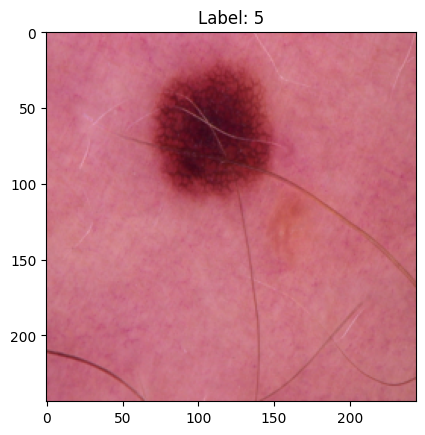

In [26]:
# Set up DataLoader for the training set
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)

# Inspect a single batch of data
for images, labels in train_loader:
    print("Image batch shape:", images.shape)  # Shape of the batch (batch_size, channels, height, width)
    print("Label batch shape:", labels.shape)  # Shape of the labels batch (batch_size,)
    print("Labels:", labels)  # Print the labels

    # Display a single image from the batch using matplotlib
    import matplotlib.pyplot as plt
    img = images[0].permute(1, 2, 0)  # Change channel order for displaying (C, H, W) -> (H, W, C)
    img = img * torch.tensor([0.5, 0.5, 0.5]) + torch.tensor([0.5, 0.5, 0.5])  # If normalized, undo normalization
    img = img.clamp(0, 1)  # Ensure the values are within [0, 1] for display

    plt.imshow(img)
    plt.title(f"Label: {labels[0].item()}")
    plt.show()
    break  # Only display the first batch

# OverSampling
